# 06 Evaluate & Interpret

## 0 Imports & global paths

In [1]:
# %% 0 Imports & Global Paths ────────────────────────────────────────
from pathlib import Path
import pandas as pd
import torch
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
from torch.utils.data import DataLoader

# repo‑aware paths ---------------------------------------------------
PROJ_ROOT   = Path.cwd().parent                      # ~/twitter‑airline‑analysis
MODEL_DIR   = PROJ_ROOT / "models" / "distilbert_twitter" / "final"
TOKEN_DIR   = MODEL_DIR / "tokenizer"
DATA_DIR    = PROJ_ROOT / "data" / "processed"
REPORTS_DIR = PROJ_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

# load tokenizer & model --------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(TOKEN_DIR,  local_files_only=True)
model     = AutoModelForSequenceClassification.from_pretrained(
               MODEL_DIR, local_files_only=True
           ).eval()          # inference mode

label_map  = model.config.id2label    # {0:'negative',1:'neutral',2:'positive'}
num_labels = len(label_map)
print("Label map:", label_map)

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Label map: {0: 'negative', 1: 'neutral', 2: 'positive'}


## 1 Load Validation & Test

In [2]:
# %% 1 Load validation / test splits ─────────────────────────────────
def _load_xy_split(split: str):
    X = pd.read_feather(DATA_DIR / f"X_{split}.ftr")["text"]
    y = pd.read_feather(DATA_DIR / f"y_{split}.ftr")["label"]
    return X.reset_index(drop=True), y.reset_index(drop=True)

X_val,  y_val  = _load_xy_split("val")
X_test, y_test = _load_xy_split("test")

for name, X, y in [("val", X_val, y_val), ("test", X_test, y_test)]:
    print(f"{name:4} rows: {len(X):,} | label dist:\n{y.value_counts()}\n")

val  rows: 1,464 | label dist:
label
negative    918
neutral     310
positive    236
Name: count, dtype: int64

test rows: 1,464 | label dist:
label
negative    918
neutral     310
positive    236
Name: count, dtype: int64



## Predict, Evaluate, Save Artefacts

In [3]:
# %% 2 Predict, Evaluate, Save Artefacts (fixed dtype mismatch) ──────
def _predict(texts, batch_size: int = 64):
    """Return (y_pred_ids, y_prob) for the given text Series."""
    loader = DataLoader(texts.tolist(), batch_size=batch_size)
    preds, probs = [], []

    with torch.no_grad():
        for batch in loader:
            enc = tokenizer(batch, padding=True, truncation=True,
                            return_tensors="pt")
            out = model(**enc)
            p = out.logits.softmax(dim=1)
            preds.extend(p.argmax(dim=1).cpu().tolist())   # ints
            probs.extend(p.cpu().tolist())                 # list[list]
    return preds, probs

# ---------- predictions -----------------------------------------------------
y_val_pred,  y_val_prob  = _predict(X_val)
y_test_pred, y_test_prob = _predict(X_test)

# ---------- convert y_true strings ➜ integer IDs ----------------------------
label2id = {v: k for k, v in model.config.id2label.items()}

y_val_ids  = y_val .map(label2id).tolist()
y_test_ids = y_test.map(label2id).tolist()

# ---------- metrics ---------------------------------------------------------
metrics = {}
for split, y_true, y_pred in [
    ("val",  y_val_ids,  y_val_pred),
    ("test", y_test_ids, y_test_pred),
]:
    metrics[split] = {
        "accuracy":  accuracy_score(y_true, y_pred),
        "macro_f1":  precision_recall_fscore_support(
                         y_true, y_pred, average="macro", zero_division=0
                     )[2],
        "report": classification_report(
                     y_true, y_pred,
                     labels=list(model.config.id2label.keys()),
                     target_names=list(model.config.id2label.values()),
                     output_dict=True, zero_division=0
                 ),
    }
print(json.dumps(
    {k: {m: round(v[m], 3) for m in ("accuracy", "macro_f1")}
     for k, v in metrics.items()}, indent=2))


{
  "val": {
    "accuracy": 0.84,
    "macro_f1": 0.798
  },
  "test": {
    "accuracy": 0.836,
    "macro_f1": 0.788
  }
}


## Confusion Matrices + per‑class ROC/PR

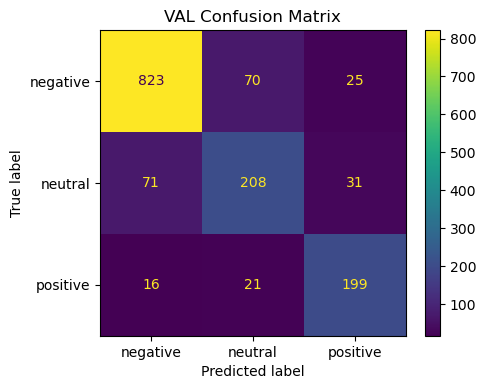

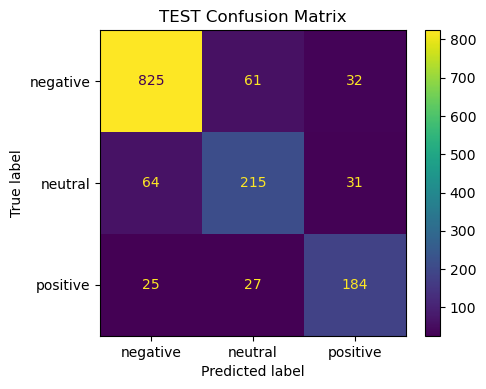

In [4]:
# %% 3 Plots: Confusion Matrix (val & test) ──────────────────────────
FIG_DIR = REPORTS_DIR / "figs_eval"
FIG_DIR.mkdir(parents=True, exist_ok=True)

for split, y_true_ids, y_pred_ids in [
    ("val",  y_val_ids,  y_val_pred),
    ("test", y_test_ids, y_test_pred),
]:
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(
        y_true_ids,
        y_pred_ids,
        labels=list(label_map.keys()),         # integer IDs 0‑2
        display_labels=list(label_map.values()),  # 'negative', 'neutral', 'positive'
        cmap="viridis",
        ax=ax,
        colorbar=True,
    )
    ax.set_title(f"{split.upper()} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"cm_{split}.png", dpi=150)
    plt.show()


## 4  Save Metrics & Model Card

In [5]:
# 1️⃣  flatten metrics (remove the nested classification report)
flat_metrics = {
    split: {k: v for k, v in d.items() if k != "report"}
    for split, d in metrics.items()
}

# 2️⃣  CSV with accuracy + macro‑F1
pd.DataFrame.from_dict(flat_metrics, orient="index").to_csv(
    REPORTS_DIR / "metrics_model.csv"
)

# 3️⃣  full JSON (includes classification reports)
with open(REPORTS_DIR / "metrics_model.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# 4️⃣  lightweight model‑card stub
card = {
    "model_name": "tweet_sentiment_distilbert",
    "num_labels": len(label_map),
    "labels": list(label_map.values()),
    "metrics": flat_metrics["val"],
}
with open(MODEL_DIR / "model_card.json", "w") as fp:
    json.dump(card, fp, indent=2)

print("✅ Artefacts written to", REPORTS_DIR.resolve())

✅ Artefacts written to C:\Projects\twitter-airline-analysis\reports
